In [38]:
from scipy.io import mmread
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import requests
from bs4 import BeautifulSoup

# Question 3

## (a) Compute a single node’s centrality in a graph

In [62]:
def katz_centrality(G, node, alpha=0.01, beta=1.0, tol=1e-6, max_iter=100):
    """
    This function takes a networkx graph and one node as input, and returns a 
    float representing the node's katz centrality without using the NetworkX 
    built-in function.

    Parameters
    ----------
    G : nx.Graph
        The input graph to be calculated.
    node : object
        The node for which to calculate centrality.
    alpha : float, optional
        Damping factor, the attenuation factor which controls the weight given to longer paths, 
        must be less than 1 / largest eigenvalue of adjacency matrix (default is 0.01).
    beta : float, optional
        Exogenous vector, base influence for each node (default is 1.0).
    tol : float, optional
        Tolerance for convergence (default is 1e-6).
    max_iter : int, optional
        Maximum number of iterations (default is 100).
    
    Returns
    -------
    float
        The katz centrality of the input node.
    """
    try:
        A = nx.to_numpy_array(G)
    except Exception:
        raise ValueError("Cannot build adjacency matrix")
        
    # Calculate the eigenvalues of A to ensure alpha is valid
    eigvals = np.linalg.eigvals(A)
    max_eigval = max(abs(val) for val in eigvals)

    # Ensure alpha is within the allowable range
    if alpha >= 1 / max_eigval:
        raise ValueError("Alpha must be less than the reciprocal of the leading eigenvalue of the adjacency matrix")

    # Initialize the centrality vector
    n_nodes = len(G)
    x = np.ones(n_nodes)
    ones = np.ones(n_nodes)

    # Iterative update
    for _ in range(max_iter):
        x_old = x.copy()
        x = alpha * A @ x + beta * ones

        # Check for convergence (if the change in centrality is below the tolerance)
        if np.linalg.norm(x - x_old, ord=1) < tol:
            break
    else:
        raise ValueError("Katz centrality did not converge within the maximum number of iterations")

    # Normalize the centrality values
    x_normalized = x / max(x)

    # Check if the node exists in the graph
    if node not in G.nodes():
        raise IndexError("Node must be in graph G")

    # Get the index of the node and return its Katz centrality
    node_index = list(G.nodes()).index(node)
    return x_normalized[node_index]
        

In [80]:
G1 = nx.erdos_renyi_graph(50, 0.2)
G2 = nx.barabasi_albert_graph(50, 3)

katz_centrality(G1, 5)
katz_centrality(G2, 5)

0.8797175260621315

In [74]:
katz_centrality_networkx = nx.katz_centrality(G2, alpha=0.01)
katz_centrality_networkx[5]

0.1434279085553505

## (b) Augment the function with error handling

i. A node that is not in the graph

ii. A graph that is not a networkx object

iii. A graph with no connectivity (or not enough connectivity to produce a valid centrality result)

iv. Any situation that might produce numerical difficulties (e.g. dividing by zero) for your chosen centrality measure


In [ ]:
def katz_centrality(G, node, alpha=0.01, beta=1.0, tol=1e-6, max_iter=100):
    """
    This function takes a networkx graph and one node as input, and returns a 
    float representing the node's katz centrality without using the NetworkX 
    built-in function.

    Parameters
    ----------
    G : nx.Graph
        The input graph to be calculated.
    node : object
        The node for which to calculate centrality.
    alpha : float, optional
        Damping factor, the attenuation factor which controls the weight given to longer paths, 
        must be less than 1 / largest eigenvalue of adjacency matrix (default is 0.01).
    beta : float, optional
        Exogenous vector, base influence for each node (default is 1.0).
    tol : float, optional
        Tolerance for convergence (default is 1e-6).
    max_iter : int, optional
        Maximum number of iterations (default is 100).
    
    Returns
    -------
    float
        The katz centrality of the input node.
    """
    # Error handling
    if not isinstance(G, (nx.Graph, nx.DiGraph)):
        raise TypeError("The input graph must be a NetworkX graph object.")
    if node not in G.nodes():
        raise IndexError("Node is not in the graph.")
    if G.number_of_nodes() == 0:
        raise ValueError("The graph has no nodes.")
    if not nx.is_connected(G):
        raise ValueError("The graph is disconnected.")
   
    try:
        A = nx.to_numpy_array(G)
    except Exception:
        raise ValueError("Cannot build adjacency matrix")
        
    # Calculate the eigenvalues of A to ensure alpha is valid
    eigvals = np.linalg.eigvals(A)
    max_eigval = max(abs(val) for val in eigvals)

    # Ensure alpha is within the allowable range
    if alpha >= 1 / max_eigval:
        raise ValueError("Alpha must be less than the reciprocal of the leading eigenvalue of the adjacency matrix")

    # Initialize the centrality vector
    n_nodes = len(G)
    x = np.ones(n_nodes)
    ones = np.ones(n_nodes)

    # Iterative update
    for _ in range(max_iter):
        x_old = x.copy()
        x = alpha * A @ x + beta * ones

        # Check for convergence (if the change in centrality is below the tolerance)
        if np.linalg.norm(x - x_old, ord=1) < tol:
            break
    else:
        raise ValueError("Katz centrality did not converge within the maximum number of iterations")

    # Normalize the centrality values
    x_normalized = x / max(x)    

    # Get the index of the node and return its Katz centrality
    node_index = list(G.nodes()).index(node)
    return x_normalized[node_index]
        

## (c) Compare with NetworkX’s built-in function

# Question 4

## (a) Scrapes a department’s course catalog and obtains links to the prerequisites of each course

In [142]:
def get_all_dept_codes():
    """
    Get all department codes from course descriptions.
    
    Returns:
    - a list of all department codes
    """
    all_dept_codes = []
    catalog_res = requests.get('https://catalog.northeastern.edu/course-descriptions/')
    catalog_html = catalog_res.text
    soup = BeautifulSoup(catalog_html)
    soup_alpha_div = soup.find('div', id='atozindex')
    dept_list = soup_alpha_div.find_all('ul')
    for i in dept_list:
        dept_soup = i.find_all('li')
        for j in dept_soup:
            all_dept_codes.append(j.a.get('href').split('/')[-2])
    
    return all_dept_codes

def get_dept_link(dept_code):
    """
    Get the department's course catalog according to the department code.
    
    Parameters:
    - dept_code: str, the code of the department.
    
    Returns:
    - a string representing the url of the department's course catalog.
    """
    
    all_dept_codes = get_all_dept_codes()
    if dept_code.lower() in all_dept_codes:
        url = f'https://catalog.northeastern.edu/course-descriptions/{dept_code}/'
        return url
    raise ValueError('Not a valid department code')

def get_prerequisites(dept_code):
    """
    Get all the prerequisites of each course from course catalog according to the department code.
    
    Parameters:
    - dept_code: str, the code of the department.
    
    Returns:
    - a dict representing all courses and their prerequisites.
    """
    
    try:
        dept_url = get_dept_link(dept_code)
    except ValueError as e:
        print(e)
        return
    
    dept_res = requests.get(dept_url)
    dept_html = dept_res.text
    dept_soup = BeautifulSoup(dept_html)
    
    course_prerequisites = {}
    
    dept_title = dept_soup.find('h1').text.strip()
    try:
        all_courses_soup = dept_soup.find('div', class_='sc_sccoursedescs').find_all('div', class_='courseblock')
        for course_soup in all_courses_soup:
            course_full_title = course_soup.find('p', class_='courseblocktitle').text.replace(u'\xa0', ' ')                                                   
            course_code = course_full_title.split('. ')[0].strip()
            course_title = course_full_title.split('. ')[1].strip()  
            prerequisites = []
            try:
                extra_soup = course_soup.find_all('p', class_='courseblockextra')
                for extra in extra_soup:
                    if 'Prerequisite(s)' in extra.text:
                        for link in extra.find_all('a', href=True):
                            prerequisites.append(link.text.replace(u'\xa0', ' '))

                course_prerequisites[course_code] = {
                    'title': course_title,
                    'prerequisites': prerequisites
                }
            except:
                # no prerequisites
                course_prerequisites[course_code] = {
                    'title': course_title,
                    'prerequisites': []
                }
    except AttributeError as e:
        print(f'{dept_code} error: {e}')
    return course_prerequisites


all_dept_codes = get_all_dept_codes()

## (b) Consturct a DAG

In [143]:
avg_dept_pre = {} # average of prerequisites per department
G = nx.DiGraph()

for dept_code in all_dept_codes:
    course_prerequisites = get_prerequisites(dept_code)
    total_prerequisites = 0
    total_courses = 0
    
    for course_code, desc in course_prerequisites.items():
        if len(desc['prerequisites']):
            total_prerequisites += 1  # assume that each course has only one prerequisite (but has different options)
        total_courses += 1
        G.add_node(course_code, title=desc['title'])
        for prerequisite in desc['prerequisites']:
            # to avoid Spanish department that a course is listed as the prerequisite at the same time
            if prerequisite.lower() != course_code.lower():
                G.add_edge(prerequisite, course_code)
        
        avg_prerequisites = total_prerequisites / total_courses if total_courses > 0 else 0
        avg_dept_pre[dept_code] = avg_prerequisites

eslg error: 'NoneType' object has no attribute 'find_all'
esl error: 'NoneType' object has no attribute 'find_all'


In [144]:
print("Number of nodes: %d" % G.number_of_nodes())
print("Number of edges: %d" % G.number_of_edges())

Number of nodes: 7845
Number of edges: 5443


## (c) Which department has the most prerequisites per course, on average? 

In [145]:
most_pre_of_dept = max(avg_dept_pre, key = avg_dept_pre.get)
most_pre_of_dept

'ls'

## (d) What is the longest chain of prerequisites?

In [146]:
# check if it is a acyclic graph
nx.is_directed_acyclic_graph(G)

False

In [152]:
# remove selfloop and cycles
G_copy = G.copy()
G_copy.remove_edges_from(nx.selfloop_edges(G_copy))

try:
    while True:
        cycle = nx.find_cycle(G_copy, orientation="original")
        if cycle:
            print(f"Detected cycle: {cycle}")
            G_copy.remove_edge(cycle[0][0], cycle[0][1])
except nx.NetworkXNoCycle:
    pass

nx.is_directed_acyclic_graph(G_copy)
print("Number of nodes: %d" % G_copy.number_of_nodes())
print("Number of edges: %d" % G_copy.number_of_edges())

Detected cycle: [('SPNS 3602', 'SPNS 3603', 'forward'), ('SPNS 3603', 'SPNS 3602', 'forward')]
Number of nodes: 7845
Number of edges: 5442


In [154]:
longest_path = nx.dag_longest_path(G_copy)
longest_path, len(longest_path)

(['BIOL 1107',
  'BIOL 1113',
  'PHSC 2301',
  'PHSC 2303',
  'HSCI 1105',
  'NRSG 2220',
  'NRSG 3323',
  'NRSG 3320',
  'NRSG 3420',
  'NRSG 4502',
  'NRSG 4995'],
 11)

# Question 5

In [4]:
# uncomment line 3 of the mtx file first
matrix = mmread('data/ca-CSphd.mtx')

G = nx.from_scipy_sparse_array(matrix)
print("Number of nodes: %d" % G.number_of_nodes())
print("Number of edges: %d" % G.number_of_edges())

Number of nodes: 1882
Number of edges: 1740


For a randomized network, we use a configuration model.

In [5]:
degree_sequence = [d for n, d in G.degree()]

G_randomized = nx.configuration_model(degree_sequence)

# remove any parallel edges
G_randomized = nx.Graph(G_randomized)

# remove self-loops
G_randomized.remove_edges_from(nx.selfloop_edges(G_randomized))

In [11]:
def get_bin_data(seq, number_of_bins=15):
    # Step 1: We will first need to define the support of our distribution
    kmax = max(seq)
    kmin = min(seq)

    # Step 2: Then we'll need to construct bins
    bins = np.linspace(kmin, kmax+1, num=number_of_bins+1)

    # Step 3: Then we can compute the histogram using numpy
    probs, _ = np.histogram(seq, bins=bins)


    # Step 4: Return not the "bins" but the midpoint between adjacent bin
    #         values. This is a better way to plot the distribution.
    bins_out = bins[1:] - np.diff(bins)/2.0
    
    return bins_out, probs

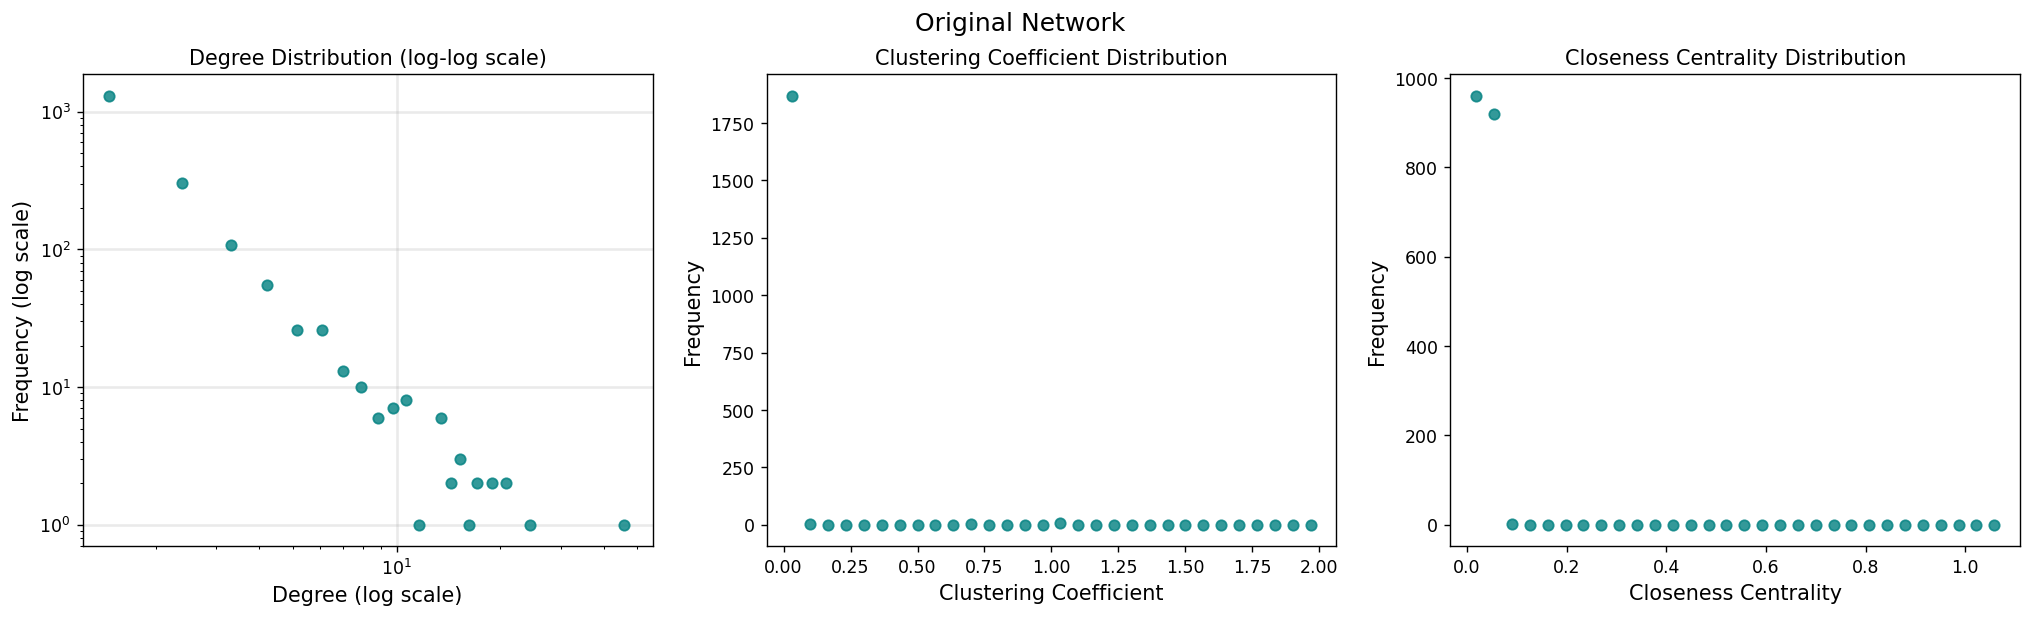

In [28]:
# Original network
fig, ax = plt.subplots(1, 3, figsize=(20, 5), dpi=125)

# 1. degree distribution with log-binning
x_0, y_0 = get_bin_data(degree_sequence, number_of_bins=50)
ax[0].loglog(x_0, y_0, 'o', color='teal', label='phd', alpha=0.8)
ax[0].set_xlabel("Degree (log scale)", fontsize='large')
ax[0].set_ylabel("Frequency (log scale)", fontsize='large')
ax[0].grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')
ax[0].set_title('Degree Distribution (log-log scale)')

# 2. clustering coefficient
clustering_coefficients = list(nx.clustering(G).values())
x_1, y_1 = get_bin_data(clustering_coefficients, number_of_bins=30)
ax[1].scatter(x_1, y_1, marker='o', color='teal', alpha=0.8)
ax[1].set_xlabel("Clustering Coefficient", fontsize='large')
ax[1].set_ylabel("Frequency", fontsize='large')
ax[1].set_title('Clustering Coefficient Distribution')

# 3. closeness centrality
closeness_centrality = list(nx.closeness_centrality(G).values())
x_2, y_2 = get_bin_data(closeness_centrality, number_of_bins=30)
ax[2].scatter(x_2, y_2, marker='o', color='teal', alpha=0.8)
ax[2].set_xlabel("Closeness Centrality", fontsize='large')
ax[2].set_ylabel("Frequency", fontsize='large')
ax[2].set_title('Closeness Centrality Distribution')

plt.suptitle("Original Network", fontsize='x-large')
plt.savefig('original_network.png', dpi=425, bbox_inches='tight')
plt.savefig('original_network.pdf', bbox_inches='tight')
plt.show()

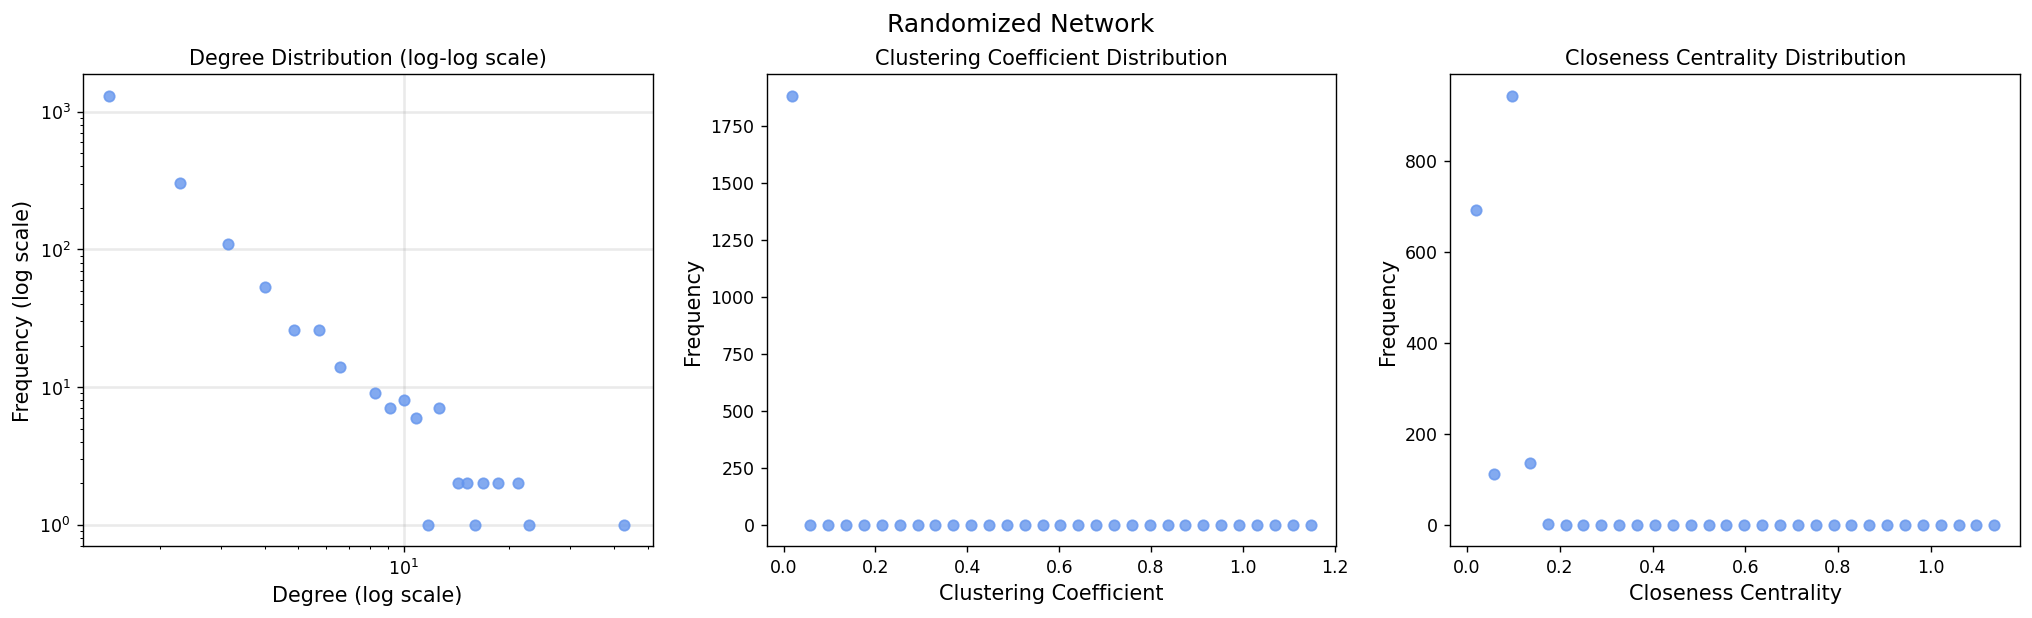

In [29]:
# Configuration model
fig, ax = plt.subplots(1, 3, figsize=(20, 5), dpi=125)
G_randomized_degree_seq = [d for n, d in G_randomized.degree()]

# 1. degree distribution with log-binning
x_0, y_0 = get_bin_data(G_randomized_degree_seq, number_of_bins=50)
ax[0].loglog(x_0, y_0, 'o', color='cornflowerblue', label='phd', alpha=0.8)
ax[0].set_xlabel("Degree (log scale)", fontsize='large')
ax[0].set_ylabel("Frequency (log scale)", fontsize='large')
ax[0].grid(linewidth=1.5, color='#999999', alpha=0.2, linestyle='-')
ax[0].set_title('Degree Distribution (log-log scale)')

# 2. clustering coefficient
clustering_coefficients = list(nx.clustering(G_randomized).values())
x_1, y_1 = get_bin_data(clustering_coefficients, number_of_bins=30)
ax[1].scatter(x_1, y_1, marker='o', color='cornflowerblue', alpha=0.8)
ax[1].set_xlabel("Clustering Coefficient", fontsize='large')
ax[1].set_ylabel("Frequency", fontsize='large')
ax[1].set_title('Clustering Coefficient Distribution')

# 3. closeness centrality
closeness_centrality = list(nx.closeness_centrality(G_randomized).values())
x_2, y_2 = get_bin_data(closeness_centrality, number_of_bins=30)
ax[2].scatter(x_2, y_2, marker='o', color='cornflowerblue', alpha=0.8)
ax[2].set_xlabel("Closeness Centrality", fontsize='large')
ax[2].set_ylabel("Frequency", fontsize='large')
ax[2].set_title('Closeness Centrality Distribution')


plt.suptitle("Randomized Network", fontsize='x-large')
plt.savefig('configuration_model.png', dpi=425, bbox_inches='tight')
plt.savefig('configuration_model.pdf', bbox_inches='tight')
plt.show()